In [2]:
import numpy as np
from numpy import sin, cos, log
from tqdm import tqdm
import matplotlib.pyplot as plt
from math import log2
import time
from scipy.stats import norm
from scipy.integrate import quad

In [2]:
def f(x):
    return np.arctan(x + np.tan(1))**2 * np.exp(-x**2/2)

# Define the integration bounds
a = -np.inf 
b = np.inf 

# Perform the numerical integration
result, error = quad(f, a, b)/np.sqrt(2*np.pi)
print(result)

iter = 10**4
T = 1
x_0 = 1
W = np.random.normal(0, T, T)
arc_tan = np.arctan(W + np.tan(x_0))
MC_approx = np.mean(arc_tan**2)
while np.abs(MC_approx - result) > 5*10**(-5):
    iter *= 10
    W = np.random.normal(0, T, iter)
    arc_tan = np.arctan(W + np.tan(x_0))
    MC_approx = np.mean(arc_tan**2)

print("Desired iterations: ", iter)


0.9214864571446697
Desired iterations:  100000000


In [9]:
K = 100
L = [0,1,2,3,4]
M = 10**5
T = 1
eps_h_l = np.zeros((len(L)-1, K))
res_h_l = np.zeros((len(L)-1, K))

for k in tqdm(range(K)):
    N_fin = 5 * 2**L[-1]
    step = T / N_fin
    W = np.vstack([np.zeros((1, M)), np.cumsum(np.random.normal(0, np.sqrt(step), (N_fin, M)), axis=0)])
    Y = np.full((len(L), M), x_0, dtype=np.float64)

    for l in range(len(L)):
        N_l = 5 * 2**L[l]
        step_l = T / N_l
        partition = (np.linspace(0, N_fin, N_l + 1)).astype(int)
        W_l = W[partition, :]
        for i in range(N_l):
            W_inc = W_l[i+1, :] - W_l[i, :]
            Y[l, :] += -np.sin(Y[l, :]) * np.cos(Y[l, :])**3 * step_l + np.cos(Y[l, :])**2 * W_inc

    eps_h_l[:, k] = np.mean(Y[:-1, :]**2 - MC_approx, axis=1)
    res_h_l[:, k] = np.mean(2 * Y[1:, :]**2 - Y[:-1, :]**2 - MC_approx, axis=1)


100%|██████████| 100/100 [01:39<00:00,  1.00it/s]


[0.2   0.1   0.05  0.025]
[0.01491182 0.00532746 0.00221167 0.00109517]
Convergence rate: 1.2569989338081287


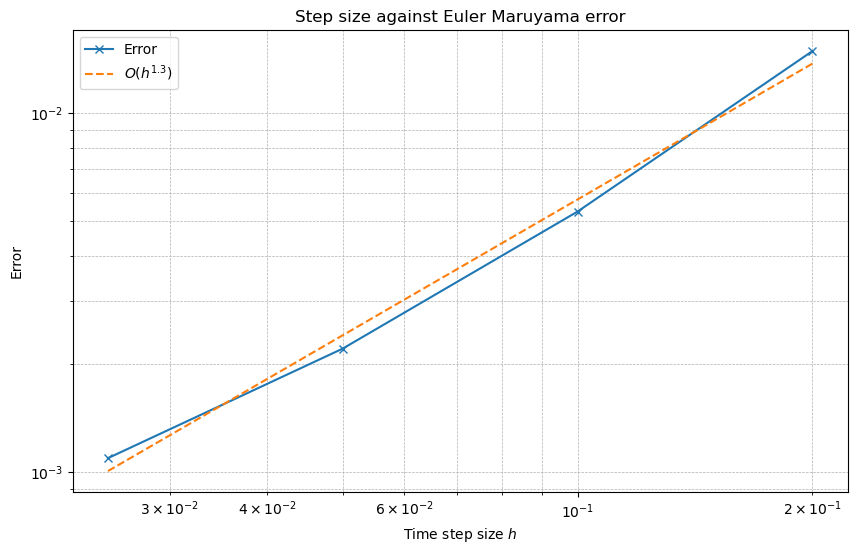

In [10]:
N_l = 5 * 2**np.array(L[:-1])
step = 1/N_l
log_step = log(step)
eps_K_mean = np.mean(eps_h_l, axis=1)
log_eps = log(abs(eps_K_mean))

print(step)
print(abs(eps_K_mean))

# Fitted line to log(Delta) vs log(YTdiff) to estimate the strong convergence rate
r = np.polyfit(log_step, log_eps, 1)

print(f'Convergence rate: {r[0]}')

# Plotting
plt.figure(figsize=(10, 6))
plt.loglog(step, abs(eps_K_mean), '-x', label='Error')
plt.loglog(step, np.exp(r[1]) * step**r[0], '--', label=f'$O(h^{{{r[0]:.1f}}})$')

plt.legend(loc='best')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xlabel('Time step size $h$')
plt.ylabel('Error')
plt.title('Step size against Euler Maruyama error')
plt.show()


Convergence rate: 2.1704591515929623


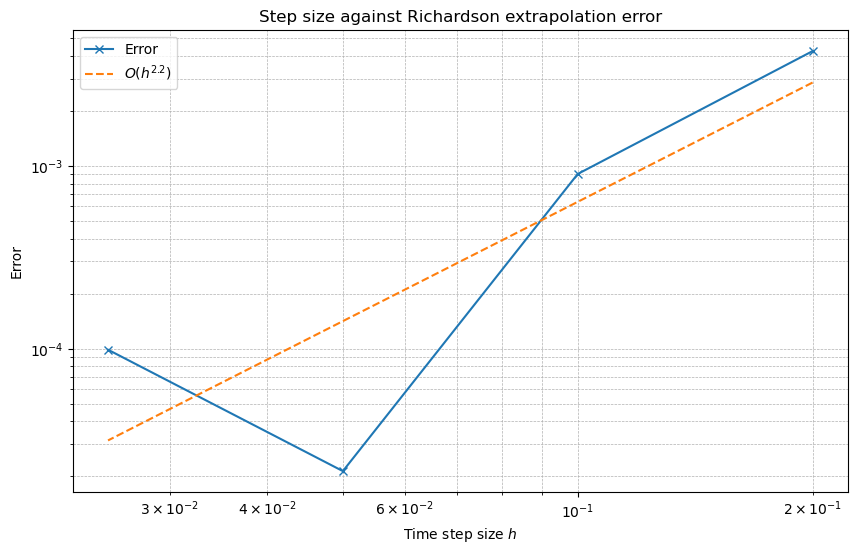

In [11]:
res_K_mean = abs(np.mean(res_h_l, axis=1))
log_res = log(res_K_mean)

# Fitted line to log(Delta) vs log(YTdiff) to estimate the strong convergence rate
r_2 = np.polyfit(log_step, log_res, 1)

print(f'Convergence rate: {r_2[0]}')

# Plotting
plt.figure(figsize=(10, 6))
plt.loglog(step, res_K_mean, '-x', label='Error')
plt.loglog(step, np.exp(r_2[1]) * step**r_2[0], '--', label=f'$O(h^{{{r_2[0]:.1f}}})$')

plt.legend(loc='best')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xlabel('Time step size $h$')
plt.ylabel('Error')
plt.title('Step size against Richardson extrapolation error')
plt.show()


We can see how the convergence rate in the Euler Maruyama approximation is of order 1.2, which is similar to the expected (order 1), and how this convergence rate gets doubled when considering the Richardson extrapolation (order 2.1, which is similar to the expected order 2).

#Exercise 2: Multi-level montecarlo Black Scholes call

In [8]:
def euler_maruyama(T, mu, sigma, xi, W):
    N = W.shape[0] - 1         # Number of equally spaced time intervals
    Delta = T / N              # Length of equally spaced time intervals
    M = W.shape[1]             # Number of samples

    # Initialize Y with the initial condition
    Y = np.full((1, M), xi)

    # Euler-Maruyama iteration
    for i in range(N):
        dW = W[i + 1, :] - W[i, :]   # Increments of the M one-dimensional Brownian motions
        Y = Y + mu(Y) * Delta + sigma(Y) * dW   # M realizations of the Euler-Maruyama approximation at t=i*Delta

    return Y

def MultiLevelMonteCarlo(T, xi, mu, sigma, epsilon, alpha, beta, gamma, f):
    # Initialize levels and parameters
    L = int(np.ceil(-log2(epsilon)))
    # Base number of time steps
    N0 = 2*T 
    # Array to store number of time steps for each level
    N = np.zeros(L, dtype=int) 

    # Number of time steps at refinement level l
    for l in range(L):
        N[l] = N0 * 2**(l+1)

    # Time step sizes for each level
    delta = T / N
    # Number of Monte Carlo samples for each level
    K = np.zeros(L, dtype=int) 
    aux_sum = 0
    for k in range(L):
        aux_sum += 2**((gamma-beta)*k/2)
    aux_sum *= 2**(2*alpha*L)
    for l in range(L):
        K[l] = np.ceil(aux_sum * 2**(-(beta+gamma)*(l+1)/2)) 

    # Level l = 1:
    W = np.vstack([np.zeros(K[0]), np.cumsum(np.random.normal(0, np.sqrt(delta[0]), (N[0], K[0])), axis=0)])
    Y = euler_maruyama(T, mu, sigma, xi, W)
    # Montecarlo average to compute E[f(Y_N)] for l=1
    E_ML = np.mean(f(Y))

    # Levels l > 1:
    for l in range(1, L):
        W_l = np.vstack([np.zeros(K[l]), np.cumsum(np.random.normal(0, np.sqrt(delta[l]), (N[l], K[l])), axis=0)])
        # This line defines the values of the BM path that will be used in the lower level
        partition = 2 * np.arange(N[l-1] + 1)
        #Brownian motion path for l-1
        W_l_inf = W_l[partition, :]
        Z1 = euler_maruyama(T, mu, sigma, xi, W_l)
        Z2 = euler_maruyama(T, mu, sigma, xi, W_l_inf)
        E_MC = np.mean(f(Z1) - f(Z2))
        # Multi-Level Monte Carlo estimation of expected value
        E_ML += E_MC 

    return E_ML


a) Test with European call option

<>:65: SyntaxWarning: invalid escape sequence '\e'
<>:66: SyntaxWarning: invalid escape sequence '\e'
<>:75: SyntaxWarning: invalid escape sequence '\e'
<>:76: SyntaxWarning: invalid escape sequence '\e'
<>:65: SyntaxWarning: invalid escape sequence '\e'
<>:66: SyntaxWarning: invalid escape sequence '\e'
<>:75: SyntaxWarning: invalid escape sequence '\e'
<>:76: SyntaxWarning: invalid escape sequence '\e'
C:\Users\oscar\AppData\Local\Temp\ipykernel_21072\2479781762.py:65: SyntaxWarning: invalid escape sequence '\e'
  plt.loglog(epsilon, np.exp(rate_epsilon_ML[1]) * epsilon**rate_epsilon_ML[0], '--', label=f'O($\epsilon^{{{rate_epsilon_ML[0]:.1f}}}$)')
C:\Users\oscar\AppData\Local\Temp\ipykernel_21072\2479781762.py:66: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('Tolerance $\epsilon$')
C:\Users\oscar\AppData\Local\Temp\ipykernel_21072\2479781762.py:75: SyntaxWarning: invalid escape sequence '\e'
  plt.loglog(epsilon, np.exp(cost_epsilon_ML[1]) * epsilon**cost_epsilon_ML[0], 

Convergence rate of the Multi-Level Monte Carlo scheme with respect to epsilon: 1.170312538549051
Overall complexity of the Multi-Level Monte Carlo method with respect to epsilon: -2.274450236663411


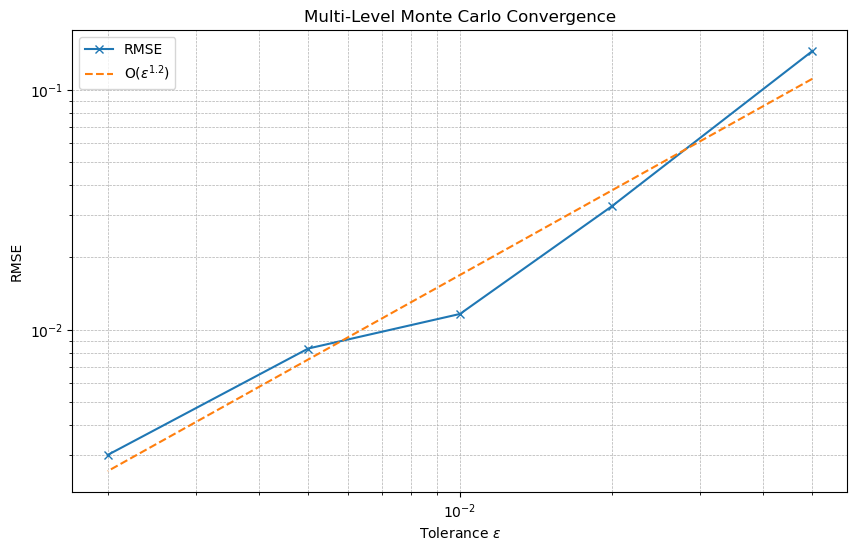

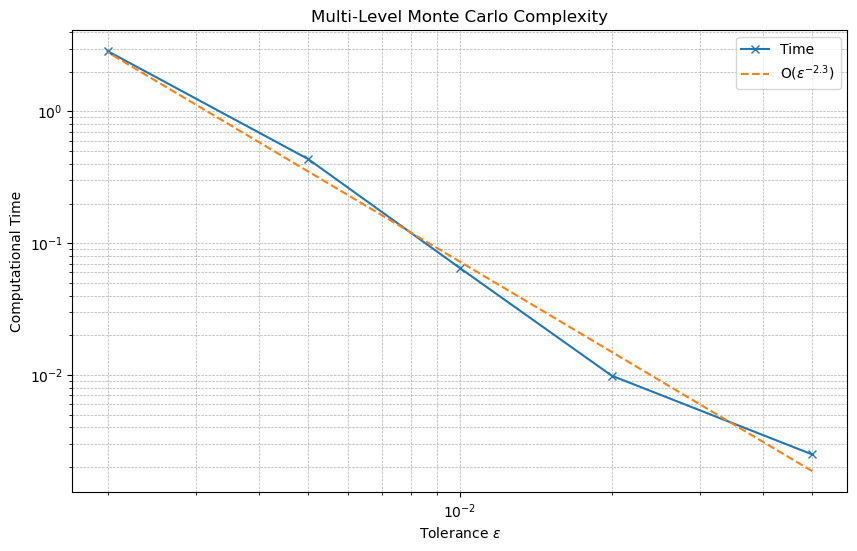

In [16]:
def black_scholes_call(S0, K, T, r, sigma):
    """
    Calculate the price of a European call option using the Black-Scholes formula.
    """
    # Calculate d1 and d2
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    # Calculate the price of the call option
    call_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Simulation parameters and initialization
epsilon = [0.05, 0.02, 0.01, 0.005, 0.002]  # Array of tolerance errors
T = 1         # Final time
M_RMSE = 10    # Number of samples for the RMSE
RMSE_ML = np.zeros((M_RMSE, len(epsilon)))  # Empty matrix to hold errors for MLMC
time_ML = np.zeros((M_RMSE, len(epsilon)))  # Empty matrix to hold computational times for MLMC

# Black-Scholes parameters and SDE coefficients
r = 0.05         # Risk-free rate
sigma = 0.1     # Volatility
mu_fun = lambda x: r * x  # Drift function for Black-Scholes model
sigma_fun = lambda x: sigma * x  # Diffusion function for Black-Scholes model
S_0 = 100       # Initial stock price
Strike = 100    # Strike price of the option
payoff = lambda x: np.maximum(x - Strike, 0)  # Payoff function (e.g., for a call option)
alpha = 1     # Parameter alpha (used in MultiLevelMonteCarlo)
beta = 1      # Parameter beta (used in MultiLevelMonteCarlo)
gamma = 2     # Parameter gamma (used in MultiLevelMonteCarlo)

# True option value by Black-Scholes formula (for comparison)
Call = black_scholes_call(S_0, Strike, T, r, sigma)  # Theoretical option value using the Black-Scholes formula

# Loop over tolerance epsilon
for k in range(M_RMSE):
    np.random.seed(12345 + k)
    for j in range(len(epsilon)):
        start_time = time.time()  # Start timer for this iteration
        
        # Multilevel montecarlo
        E_ML = MultiLevelMonteCarlo(T, S_0, mu_fun, sigma_fun, epsilon[j], alpha, beta, gamma, payoff) * np.exp(-r*T)
        
        # Calculate the error (difference between estimated and true value)
        RMSE_ML[k, j] = np.abs(E_ML - Call)
        
        # Record the computational time
        time_ML[k, j] = time.time() - start_time

# Calculate the average RMSE and computational time
RMSE_ML = np.sqrt(np.mean(RMSE_ML**2, axis=0))
time_ML = np.mean(time_ML, axis=0)

# Compute convergence rates for RMSE
rate_epsilon_ML = np.polyfit(np.log(epsilon), np.log(RMSE_ML), 1)
print(f'Convergence rate of the Multi-Level Monte Carlo scheme with respect to epsilon: {rate_epsilon_ML[0]}')

# Compute convergence rates for computational cost
cost_epsilon_ML = np.polyfit(np.log(epsilon), np.log(time_ML), 1)
print(f'Overall complexity of the Multi-Level Monte Carlo method with respect to epsilon: {cost_epsilon_ML[0]}')

# Plotting RMSE and computational time vs epsilon
plt.figure(figsize=(10, 6))
plt.loglog(epsilon, RMSE_ML, '-x', label='RMSE')
plt.loglog(epsilon, np.exp(rate_epsilon_ML[1]) * epsilon**rate_epsilon_ML[0], '--', label=f'O($\epsilon^{{{rate_epsilon_ML[0]:.1f}}}$)')
plt.xlabel('Tolerance $\epsilon$')
plt.ylabel('RMSE')
plt.title('Multi-Level Monte Carlo Convergence')
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

plt.figure(figsize=(10, 6))
plt.loglog(epsilon, time_ML, '-x', label='Time')
plt.loglog(epsilon, np.exp(cost_epsilon_ML[1]) * epsilon**cost_epsilon_ML[0], '--', label=f'O($\epsilon^{{{cost_epsilon_ML[0]:.1f}}}$)')
plt.xlabel('Tolerance $\epsilon$')
plt.ylabel('Computational Time')
plt.title('Multi-Level Monte Carlo Complexity')
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


From this results, we see a convergence rate equal to 1.2, which is better than the one obtained in next section (MC Euler). And a complexity slope lower in absolute value in comparison to the the MC Euler. Hence, it proves this better results. 

b) Monte Carlo - Euler for European call option

As we want the error from the MC averaging (statistical error) and the error from the EM approximation must be equilibrated in the root mean squared error sense, we take K to be equal to N^2, as we know that the error is bounded by 1/(sqrt(K)) + 1/N.

<>:61: SyntaxWarning: invalid escape sequence '\e'
<>:62: SyntaxWarning: invalid escape sequence '\e'
<>:71: SyntaxWarning: invalid escape sequence '\e'
<>:72: SyntaxWarning: invalid escape sequence '\e'
<>:61: SyntaxWarning: invalid escape sequence '\e'
<>:62: SyntaxWarning: invalid escape sequence '\e'
<>:71: SyntaxWarning: invalid escape sequence '\e'
<>:72: SyntaxWarning: invalid escape sequence '\e'
C:\Users\oscar\AppData\Local\Temp\ipykernel_21072\1269483364.py:61: SyntaxWarning: invalid escape sequence '\e'
  plt.loglog(epsilon, np.exp(rate_epsilon_MC[1]) * epsilon**rate_epsilon_MC[0], '--', label=f'O($\epsilon^{{{rate_epsilon_MC[0]:.1f}}}$)')
C:\Users\oscar\AppData\Local\Temp\ipykernel_21072\1269483364.py:62: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('Tolerance $\epsilon$')
C:\Users\oscar\AppData\Local\Temp\ipykernel_21072\1269483364.py:71: SyntaxWarning: invalid escape sequence '\e'
  plt.loglog(epsilon, np.exp(cost_epsilon_MC[1]) * epsilon**cost_epsilon_MC[0], 

Convergence rate of the Monte Carlo scheme with respect to epsilon: 0.8997659613995382
Overall complexity of the Monte Carlo method with respect to epsilon: -2.751697711422814


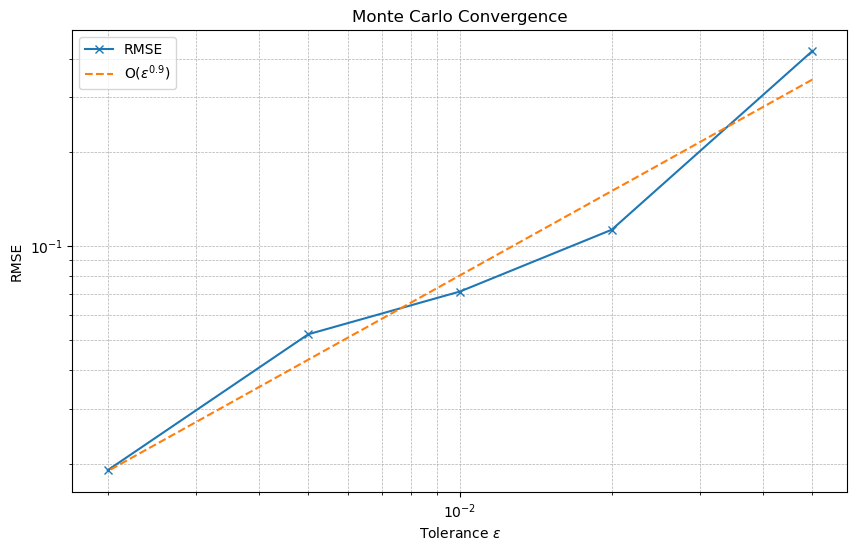

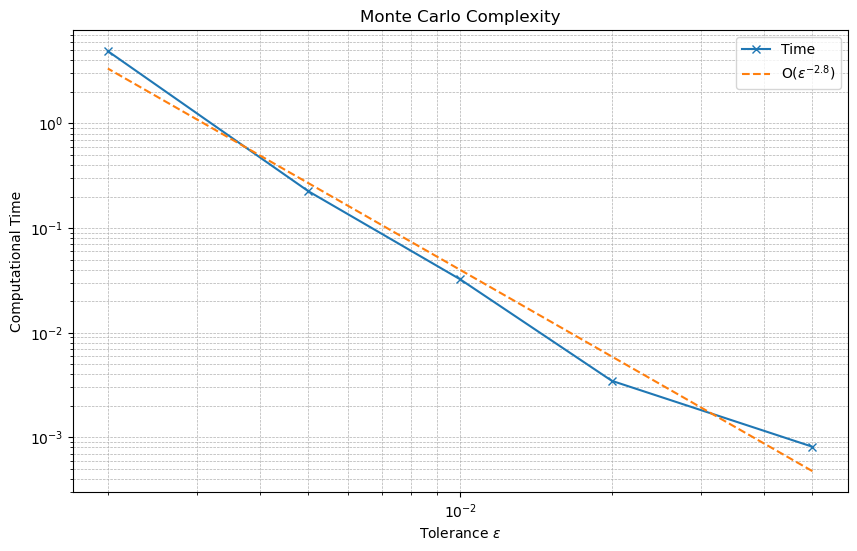

In [12]:
def MonteCarloEuler(T, epsilon, xi, mu, sigma, f):
    """
    Monte Carlo-Euler scheme to approximate E(f(X_T)) where the
    SDE X_t = mu(X_t) dt + sigma(X_t) dW_t
        X_0 = xi; t in [0,T] is solved
    using the Euler-Maruyama method.
    """

    # Step size of Euler scheme
    N = int(T / epsilon)
    # Number of montecarlo samples
    M = N**2

    # Sample M paths of a m-dimensional Brownian motion
    W = np.vstack([np.zeros(M), np.sqrt(epsilon) * np.cumsum(np.random.randn(N, M), axis=0)])

    # Call Euler-Maruyama scheme
    Y = euler_maruyama(T, mu, sigma, xi, W)

    # Monte Carlo estimation of expected value
    E_MC = np.mean(f(Y), axis=1)

    return E_MC

M_RMSE = 10
epsilon = [0.05, 0.02, 0.01, 0.005, 0.002]
T = 1
RMSE_MC = np.zeros((M_RMSE, len(epsilon)))  # Empty matrix to hold errors for MC
time_MC = np.zeros((M_RMSE, len(epsilon)))  # Empty matrix to hold computational times for MC

# Loop over tolerance epsilon
for k in tqdm(range(M_RMSE)):
    np.random.seed(12 + k)
    for j in range(len(epsilon)):
        start_time = time.time()  # Start timer for this iteration
        
        # Monte Carlo Euler
        E_MC = MonteCarloEuler(T, epsilon[j], S_0, mu_fun, sigma_fun, payoff) * np.exp(-r*T)
        
        # Calculate the error (difference between estimated and true value)
        RMSE_MC[k, j] = np.abs(E_MC - Call)
        
        # Record the computational time
        time_MC[k, j] = time.time() - start_time

# Calculate the average RMSE and computational time
RMSE_MC = np.sqrt(np.mean(RMSE_MC**2, axis=0))
time_MC = np.mean(time_MC, axis=0)

# Compute convergence rates for RMSE
rate_epsilon_MC = np.polyfit(np.log(epsilon), np.log(RMSE_MC), 1)
print(f'Convergence rate of the Monte Carlo scheme with respect to epsilon: {rate_epsilon_MC[0]}')

# Compute convergence rates for computational cost
cost_epsilon_MC = np.polyfit(np.log(epsilon), np.log(time_MC), 1)
print(f'Overall complexity of the Monte Carlo method with respect to epsilon: {cost_epsilon_MC[0]}')

# Plotting RMSE and computational time vs epsilon
plt.figure(figsize=(10, 6))
plt.loglog(epsilon, RMSE_MC, '-x', label='RMSE')
plt.loglog(epsilon, np.exp(rate_epsilon_MC[1]) * epsilon**rate_epsilon_MC[0], '--', label=f'O($\epsilon^{{{rate_epsilon_MC[0]:.1f}}}$)')
plt.xlabel('Tolerance $\epsilon$')
plt.ylabel('RMSE')
plt.title('Monte Carlo Convergence')
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

plt.figure(figsize=(10, 6))
plt.loglog(epsilon, time_MC, '-x', label='Time')
plt.loglog(epsilon, np.exp(cost_epsilon_MC[1]) * epsilon**cost_epsilon_MC[0], '--', label=f'O($\epsilon^{{{cost_epsilon_MC[0]:.1f}}}$)')
plt.xlabel('Tolerance $\epsilon$')
plt.ylabel('Computational Time')
plt.title('Monte Carlo Complexity')
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


We can appreciate how we have a convergence rate of 1, as we where expecting. As we know that EM converges with this rate, and also, we are assuming that the stepsze and K value reduces in the same way, so we can conclude that our error will be not grater than C1/N. As K and K can be unified in a single term (K=N^2).

We can deduce from our results, that the work (complexity) increases linearly (in the log sense), as time step decreases, and this is due to the fact that the work comes from the sampling (K) of montecarlo and the time steps(N), and we make them to be in a way that they are equivalent. Do the increase in time steps also increase the number of samples in a way that this log plot looks linear. 
In comparison to MultiLevel MC, we get lowe convergence rate and a higher negative slope in complexity. Hence, it is negative for our computational cost.